# Phần 1: Chọn mô hình

#1.Import thư viện

In [1]:
# !pip install pandas numpy matplotlib seaborn lifetimes scikit-learn xgboost tqdm
# !pip install lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score


import warnings
warnings.filterwarnings('ignore')


sns.set_style('whitegrid')
plt.rcParams['figure.dpi']=120

#2.Load Data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
customers = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_customers_dataset.csv")
orders = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_orders_dataset.csv")
items = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_items_dataset.csv")
payments = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_payments_dataset.csv")
reviews = pd.read_csv("C:/Users/meta/Documents/Olist 10.11/olist_order_reviews_dataset.csv")

In [4]:
# Kiểm tra nhanh kích thước và cột
print(customers.shape, orders.shape, items.shape, payments.shape, reviews.shape)
orders.head(3)

(99441, 5) (99441, 8) (112650, 7) (103886, 5) (99224, 7)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


## 2.1. Table orders

In [5]:
orders.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
#Tạo funtion để tính tỉ lệ giá trị bị null trong các hàng
def calc_null_rate(df):
  newdf=df.isnull().sum().to_frame('null_count')
  newdf[['null_rate']]=newdf[['null_count']]/len(df)
  return newdf.sort_values(by=['null_rate'],ascending=False)

In [8]:
calc_null_rate(orders)

,null_count,null_rate
order_delivered_customer_date,2965,0.029817
order_delivered_carrier_date,1783,0.017930
order_approved_at,160,0.001609
order_id,0,0.000000
order_purchase_timestamp,0,0.000000
order_status,0,0.000000
customer_id,0,0.000000
order_estimated_delivery_date,0,0.000000


* Nhận xét: 3 cột đầu tiên có giá trị null nhưng phần phân tích phía dưới không dùng nên sẽ lược bỏ

In [9]:
orders['order_status'].value_counts(normalize=True) * 100

order_status
delivered      97.020344
shipped         1.113223
canceled        0.628513
unavailable     0.612423
invoiced        0.315765
processing      0.302692
created         0.005028
approved        0.002011
Name: proportion, dtype: float64

* Lưu ý: Ở phần phân tích phía sau, chỉ giữ lại các đơn hàng đã có trạng thái chuyển "delivered"

## 2.2. Table items

In [10]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79


In [11]:
items.head(4)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79


In [12]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [13]:
calc_null_rate(items)

,null_count,null_rate
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [14]:
items['order_id'].nunique()

98666

Nhận xét: Vì mỗi đơn hàng có nhiều order_item khác nhau

In [15]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


+ Nhận xét: Cột price và freight value không xuất hiện giá trị âm => Phù hợp

In [16]:
# Kiểm tra tỷ lệ freight_value = 0
zero_freight = (items['freight_value'] == 0).sum()
total_rows = len(items)
print(f"Số dòng freight_value = 0: {zero_freight} ({zero_freight/total_rows*100:.2f}%)")

Số dòng freight_value = 0: 383 (0.34%)


+ Nhận xét: Có thể đây là những đơn hàng freeship nên giá trị vận chuyển = 0 là bình thường

## 2.3. Table customers

In [17]:
customers.head(4)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP


In [18]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [19]:
customers['customer_id'].nunique()

99441

In [20]:
customers['customer_unique_id'].nunique()

96096

* Nhận xét:
  + Có 99,441 đơn hàng được gán cho 96,096 khách hàng thực tế
  → Tức là chỉ khoảng 3,345 khách hàng đã mua từ 2 lần trở lên

In [21]:
repeat_customers = (
    customers.groupby('customer_unique_id')['customer_id']
    .nunique()
    .reset_index(name='order_count')
)

repeat_customers['is_repeat'] = repeat_customers['order_count'] > 1
repeat_customers['is_repeat'].value_counts(normalize=True) * 100

is_repeat
False    96.881244
True      3.118756
Name: proportion, dtype: float64

→ Nghĩa là khoảng 3.12% khách hàng thực đã mua nhiều hơn 1 lần và gần 97% khách hàng chỉ mua 1 lần duy nhất

In [22]:
# Check qua số khách hàng ở mỗi tháng

# Gộp 2 bảng qua khóa customer_id
orders_cust = orders.merge(customers, on='customer_id', how='left')

# Chuyển cột thời gian sang datetime
orders_cust['order_date'] = pd.to_datetime(orders_cust['order_purchase_timestamp'])

# Tạo cột tháng
orders_cust['order_month'] = orders_cust['order_date'].dt.to_period('M')

# Tính số khách hàng unique mỗi tháng (dựa trên customer_unique_id)
unique_users_by_month = (
    orders_cust.groupby('order_month')['customer_unique_id']
    .nunique()
    .reset_index()
    .rename(columns={'customer_unique_id': 'n_unique_users'})
)

# Chuyển order_month về dạng timestamp
unique_users_by_month['order_month'] = unique_users_by_month['order_month'].dt.to_timestamp()

# In kết quả
print(unique_users_by_month.head(30))

   order_month  n_unique_users
0   2016-09-01               4
1   2016-10-01             321
2   2016-12-01               1
3   2017-01-01             765
4   2017-02-01            1755
5   2017-03-01            2642
6   2017-04-01            2372
7   2017-05-01            3625
8   2017-06-01            3180
9   2017-07-01            3947
10  2017-08-01            4246
11  2017-09-01            4212
12  2017-10-01            4561
13  2017-11-01            7430
14  2017-12-01            5603
15  2018-01-01            7166
16  2018-02-01            6569
17  2018-03-01            7115
18  2018-04-01            6882
19  2018-05-01            6814
20  2018-06-01            6128
21  2018-07-01            6230
22  2018-08-01            6460
23  2018-09-01              14
24  2018-10-01               4


* Nhận xét: Mặc dù Dataset từ 9/2016 - 10/2018, tuy nhiên bị thiếu dữ liệu của tháng 11/2016, đồng thời số khách hàng của tháng 9,10,12 năm 2016 và tháng 9,10 của năm 2018 rất nhỏ
  * Vì thế, bài phân tích chỉ tập trung vào khoảng 1/2017 đến 6/2018

#3.Gộp bảng và lọc điều kiện

In [23]:
# Giữ đơn đã giao thành công
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')

# Tính giá trị đơn hàng = price + freight_value
items['order_value'] = items['price'] + items['freight_value']
order_val = items.groupby('order_id', as_index=False)['order_value'].sum()

# Merge bảng giao dịch cơ bản (1 dòng = 1 order)
trans = (
    orders[['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(order_val, on='order_id', how='left')
    .merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')
    .rename(columns={'order_purchase_timestamp': 'order_date'})
    [['order_id', 'customer_unique_id', 'order_date', 'order_value', 'customer_state']]
    .dropna()
    .drop_duplicates()
)
trans['order_date'] = pd.to_datetime(trans['order_date'], errors='coerce')

# Giữ lại dữ liệu từ 01/01/2017 trở đi
trans = trans[trans['order_date'] >= '2017-01-01']
print("Tổng số giao dịch:", len(trans))
trans.head(3)


Tổng số giao dịch: 96211


,order_id,customer_unique_id,order_date,order_value,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,38.71,SP
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,141.46,BA
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,179.12,GO


In [24]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96211 entries, 0 to 96477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            96211 non-null  object        
 1   customer_unique_id  96211 non-null  object        
 2   order_date          96211 non-null  datetime64[ns]
 3   order_value         96211 non-null  float64       
 4   customer_state      96211 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.4+ MB


In [25]:
calc_null_rate(trans)

,null_count,null_rate
order_id,0,0.0
customer_unique_id,0,0.0
order_date,0,0.0
order_value,0,0.0
customer_state,0,0.0


#4.EDA (phân phối & đặc điểm dữ liệu)

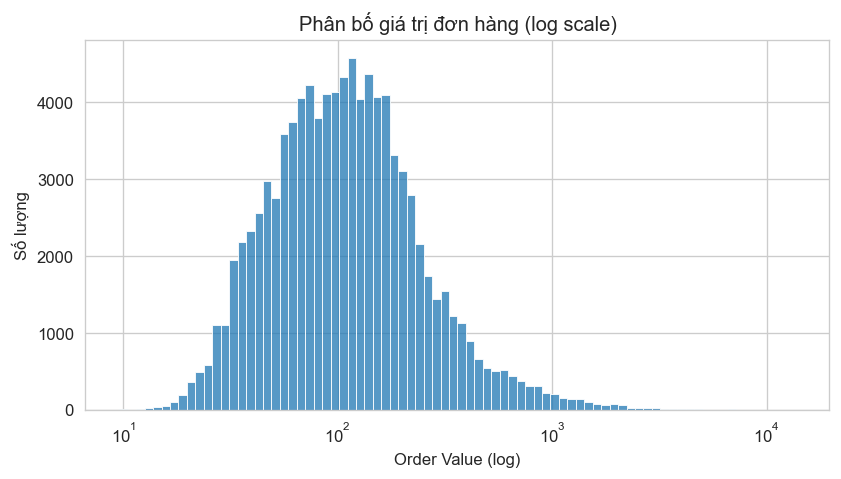

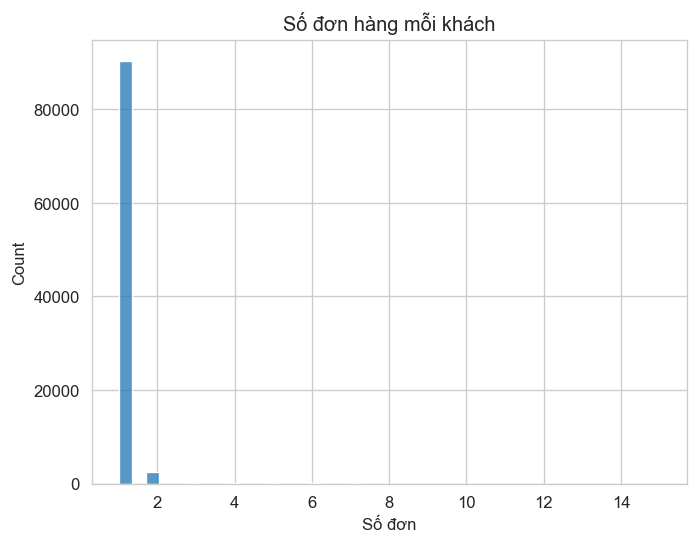

Tỷ lệ khách chỉ mua 1 lần: 97.0 %


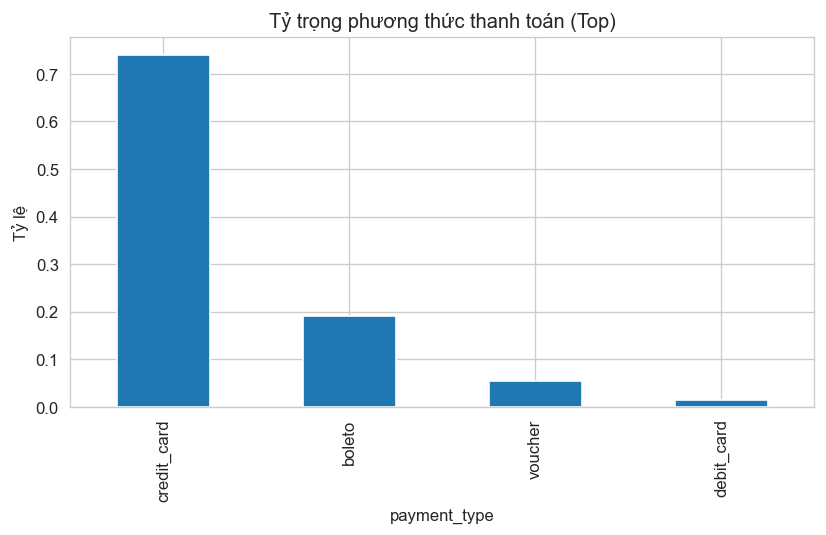

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(trans['order_value'], bins=80, log_scale=True)
plt.title("Phân bố giá trị đơn hàng (log scale)")
plt.xlabel("Order Value (log)")
plt.ylabel("Số lượng"); plt.show()

# Phân phối số đơn theo khách
cust_orders = trans.groupby('customer_unique_id')['order_id'].nunique()
sns.histplot(cust_orders, bins=40)
plt.title("Số đơn hàng mỗi khách"); plt.xlabel("Số đơn"); plt.show()
print("Tỷ lệ khách chỉ mua 1 lần:", (cust_orders.eq(1).mean()*100).round(2), "%")

# Tỷ trọng phương thức thanh toán
pm = payments.merge(orders[['order_id']], on='order_id', how='inner')
share = pm['payment_type'].value_counts(normalize=True).head(6)
share.plot(kind='bar', figsize=(8,4))
plt.title("Tỷ trọng phương thức thanh toán (Top)"); plt.ylabel("Tỷ lệ"); plt.show()


#5.Tách thời gian (Cutoff & Horizon) + Chia Train/Test

Train orders: 43357 | Test (horizon): 40344


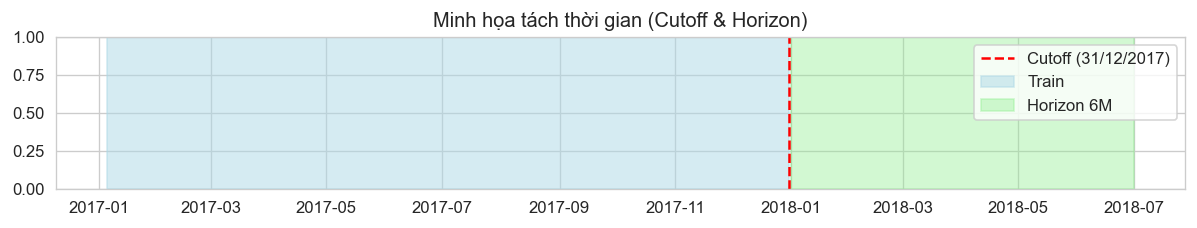

In [27]:
# Thiết lập mốc thời gian tách dữ liệu (temporal split)
# - CUTOFF: mốc tách train/test (31/12/2017)
# - H_START, H_END: giai đoạn dự báo CLV (01/2018–06/2018)
# - SNAPSHOT: điểm tham chiếu tính Recency
CUTOFF  = pd.Timestamp('2017-12-31')
H_START = CUTOFF + pd.Timedelta(days=1)
H_END   = H_START + pd.DateOffset(months=6)
SNAPSHOT = CUTOFF + pd.Timedelta(days=1)

# Chia dữ liệu:
# - train_tx: giao dịch trước cutoff (dùng huấn luyện)
# - test_tx : giao dịch sau cutoff (dùng đánh giá CLV thực tế)
train_tx = trans[trans['order_date'] <= CUTOFF].copy()
test_tx  = trans[(trans['order_date'] > CUTOFF) & (trans['order_date'] <= H_END)].copy()

# ⚠️ Lưu ý: Khách hàng chỉ xuất hiện sau cutoff (cold-start) sẽ bị loại tự động
# vì không có lịch sử trong train_tx → không thể dự báo CLV
print("Train orders:", len(train_tx), "| Test (horizon):", len(test_tx))

# Minh họa trực quan Cutoff & Horizon
plt.figure(figsize=(10,2))
plt.axvline(CUTOFF, color='r', linestyle='--', label='Cutoff (31/12/2017)')
plt.axvspan(train_tx['order_date'].min(), CUTOFF, color='lightblue', alpha=0.5, label='Train')
plt.axvspan(H_START, H_END, color='lightgreen', alpha=0.4, label='Horizon 6M')
plt.title("Minh họa tách thời gian (Cutoff & Horizon)")
plt.legend(); plt.tight_layout(); plt.show()


In [28]:
train_tx['customer_unique_id'].nunique()

42066

In [29]:
train_tx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43357 entries, 0 to 96475
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            43357 non-null  object        
 1   customer_unique_id  43357 non-null  object        
 2   order_date          43357 non-null  datetime64[ns]
 3   order_value         43357 non-null  float64       
 4   customer_state      43357 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ MB


#6.Tính RFM (Recency–Frequency–Monetary)

In [30]:
rfm = (
    train_tx.groupby('customer_unique_id')
    .agg(last=('order_date', 'max'),
         first=('order_date', 'min'),
         num=('order_id', 'nunique'),
         spent=('order_value', 'sum'))
)
rfm['recency']   = (SNAPSHOT - rfm['last']).dt.days
rfm['T']         = (SNAPSHOT - rfm['first']).dt.days
rfm['frequency'] = rfm['num'] - 1
rfm['monetary']  = rfm['spent'] / rfm['num']

rfm_simple = rfm[['recency', 'frequency', 'monetary']].reset_index()
print("Số khách hàng:", len(rfm_simple))
rfm_simple.head(3)


Số khách hàng: 42066


,customer_unique_id,recency,frequency,monetary
0,0000f46a3911fa3c0805444483337064,296,0,86.22
1,0000f6ccb0745a6a4b88665a16c9f078,80,0,43.62
2,0004aac84e0df4da2b147fca70cf8255,47,0,196.89



📊 Phân phối tần suất mua hàng (Frequency):
frequency_group  count  percent
              0  40897    97.22
              1   1076     2.56
              2     74     0.18
              3     13     0.03
             >4      6     0.01


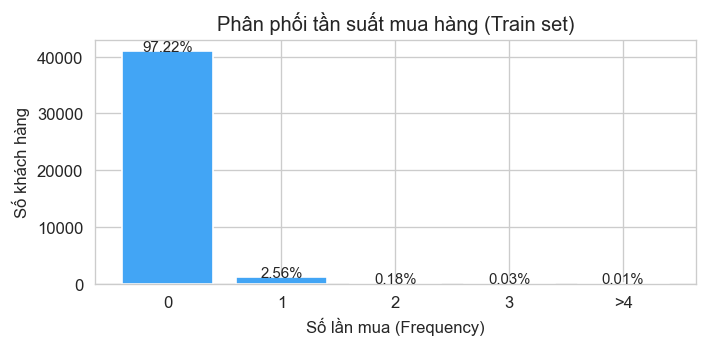

In [31]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Nhóm frequency thành 5 mức: 0,1,2,3,>4
bins = [-1, 0, 1, 2, 3, np.inf]
labels = ['0', '1', '2', '3', '>4']
rfm_simple['freq_group'] = pd.cut(rfm_simple['frequency'], bins=bins, labels=labels)

# Đếm số khách hàng và tỷ lệ %
freq_summary = (
    rfm_simple['freq_group']
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'index': 'frequency_group', 'freq_group': 'count'})  # sửa ở đây
)

# 🛠️ Sửa tên đúng của cột đếm
freq_summary.columns = ['frequency_group', 'count']

# Ép kiểu sang int
freq_summary['count'] = freq_summary['count'].astype(int)

# Thêm cột % khách hàng
freq_summary['percent'] = (freq_summary['count'] / freq_summary['count'].sum() * 100).round(2)

print("\n📊 Phân phối tần suất mua hàng (Frequency):")
print(freq_summary.to_string(index=False))

# (Tùy chọn) Vẽ biểu đồ
plt.figure(figsize=(6,3))
plt.bar(freq_summary['frequency_group'], freq_summary['count'], color='#42A5F5')
plt.xlabel("Số lần mua (Frequency)")
plt.ylabel("Số khách hàng")
plt.title("Phân phối tần suất mua hàng (Train set)")
for i, v in enumerate(freq_summary['count']):
    plt.text(i, v + 5, f"{freq_summary['percent'][i]}%", ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Thêm

In [32]:
# 2️⃣ Tính RFM không trừ 1 (dùng cho phân tích hành vi)
rfm_nominus = (
    train_tx.groupby('customer_unique_id')
    .agg(last=('order_date', 'max'),
         first=('order_date', 'min'),
         num=('order_id', 'nunique'),
         spent=('order_value', 'sum'))
)

rfm_nominus['recency']   = (SNAPSHOT - rfm_nominus['last']).dt.days
rfm_nominus['T']         = (SNAPSHOT - rfm_nominus['first']).dt.days
rfm_nominus['frequency'] = rfm_nominus['num']      # không trừ 1
rfm_nominus['monetary']  = rfm_nominus['spent'] / rfm_nominus['num']

rfm_nominus = rfm_nominus[['recency', 'frequency', 'T', 'monetary']].reset_index()
rfm_nominus['type'] = 'RFM_raw'


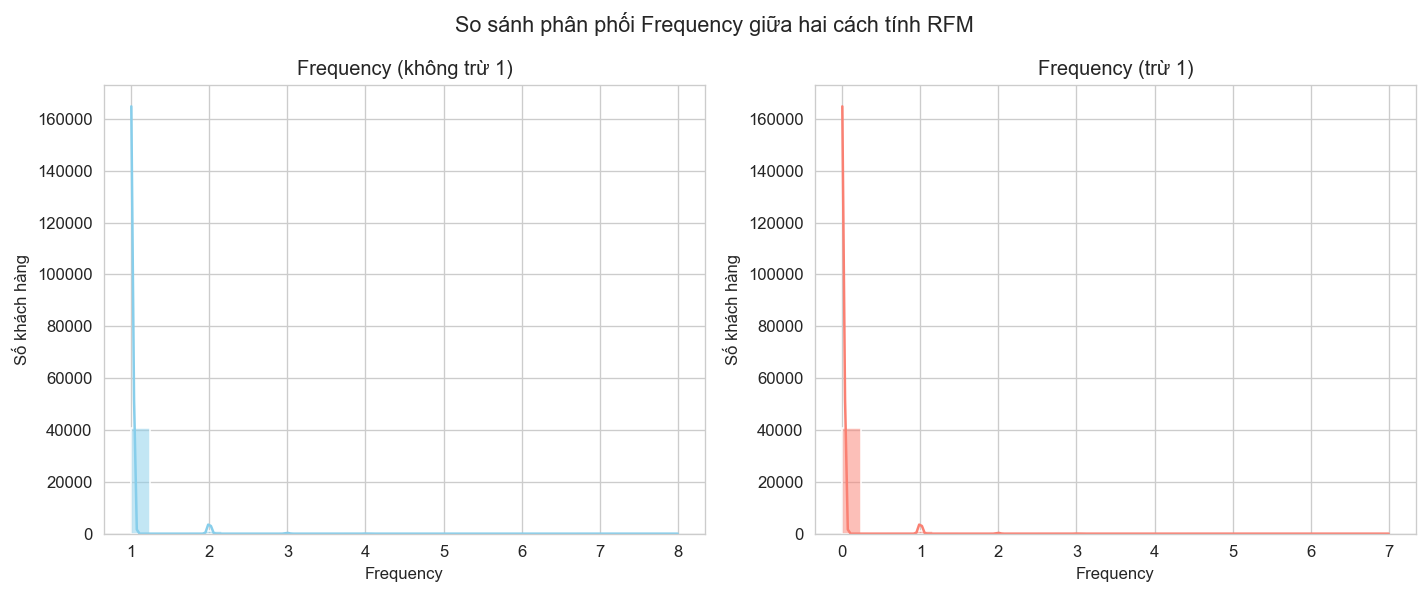

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(rfm_nominus['frequency'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title("Frequency (không trừ 1)")

sns.histplot(rfm_simple['frequency'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title("Frequency (trừ 1)")

for ax in axes:
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Số khách hàng")

plt.suptitle("So sánh phân phối Frequency giữa hai cách tính RFM", fontsize=13)
plt.tight_layout()
plt.show()


#7.Cohort Retention

In [34]:
train_tx['order_month'] = train_tx['order_date'].dt.to_period('M')
first_month = train_tx.groupby('customer_unique_id')['order_month'].min().rename('cohort')
cohort_df = train_tx.merge(first_month, on='customer_unique_id', how='left')
cohort_df['cohort_index'] = (cohort_df['order_month'] - cohort_df['cohort']).apply(lambda p: p.n)

cohort_pivot = (
    cohort_df.groupby(['cohort', 'cohort_index'])['customer_unique_id']
    .nunique().unstack(1).fillna(0)
)
retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)


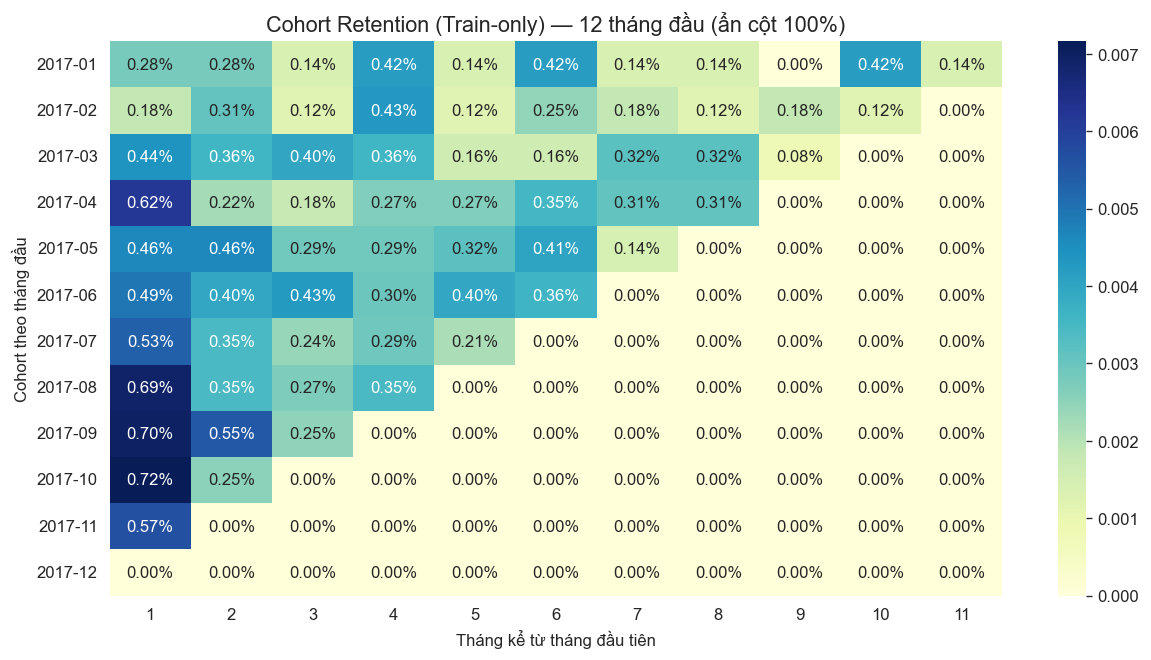

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Bỏ cột 0 (tháng đầu = 100%)
sns.heatmap(
    retention.iloc[:, 1:13],    # chỉ lấy từ tháng 1 đến tháng 12
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=True
)

plt.title("Cohort Retention (Train-only) — 12 tháng đầu (ẩn cột 100%)", fontsize=13)
plt.ylabel("Cohort theo tháng đầu")
plt.xlabel("Tháng kể từ tháng đầu tiên")
plt.show()


* Nhận xét tổng quan:
  - Tỷ lệ quay lại nhìn chung rất thấp, chỉ dao động quanh 0.2–0.7% ở tháng kế tiếp, rồi giảm nhanh về gần 0% sau 3–4 tháng.

  - Đa số cohort đều có hiện tượng “rơi rụng nhanh”, đặc biệt từ tháng thứ 4 trở đi, gần như không còn khách quay lại.

  - Điều này cho thấy phần lớn khách hàng chỉ phát sinh một lần mua, đúng với mô tả “one-time heavy” thường thấy trong thương mại điện tử marketplace.

#8.Baseline CLV – Fit BG/NBD & Gamma–Gamma (Feature Engineering II)

In [36]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# Tạo bảng tóm tắt hành vi mua (input cho lifetimes)
summary = summary_data_from_transaction_data(
    transactions=train_tx,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    monetary_value_col='order_value',
    observation_period_end=SNAPSHOT,
    freq='D'
).reset_index()
summary.head(5)

,customer_unique_id,frequency,recency,T,monetary_value
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0


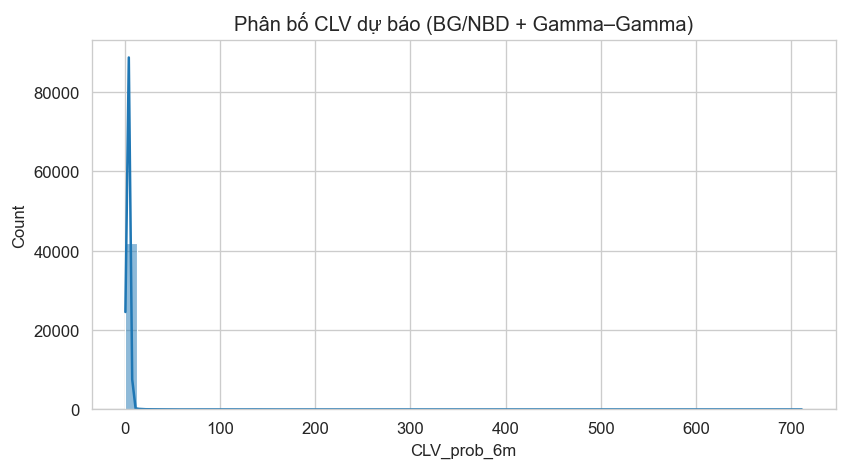

In [37]:
# Fit mô hình BG/NBD (tần suất mua)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit mô hình Gamma–Gamma (chi tiêu trung bình)
mask_rep = (summary['frequency'] > 0) & (summary['monetary_value'] > 0)
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary.loc[mask_rep,'frequency'], summary.loc[mask_rep,'monetary_value'])

# Dự báo số lần mua và chi tiêu trong 6 tháng tới
H_days = (H_END - H_START).days + 1
summary['pred_purchases_6m'] = bgf.predict(H_days, summary['frequency'], summary['recency'], summary['T'])
summary['pred_avg_value']    = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary['CLV_prob_6m']       = summary['pred_purchases_6m'] * summary['pred_avg_value']

# Xác suất còn hoạt động
summary['p_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

# Biểu đồ phân phối CLV dự báo
plt.figure(figsize=(8,4))
sns.histplot(summary['CLV_prob_6m'], bins=60, kde=True)
plt.title('Phân bố CLV dự báo (BG/NBD + Gamma–Gamma)')
plt.xlabel('CLV_prob_6m'); plt.show()

* Nhận xét:
  - Phân phối CLV dự báo (BG/NBD + Gamma–Gamma) cho thấy giá trị rất lệch phải, phần lớn khách hàng có CLV thấp trong khi chỉ một số ít có giá trị cao vượt trội --> Phản ánh sự tập trung giá trị trong nhóm nhỏ khách hàng

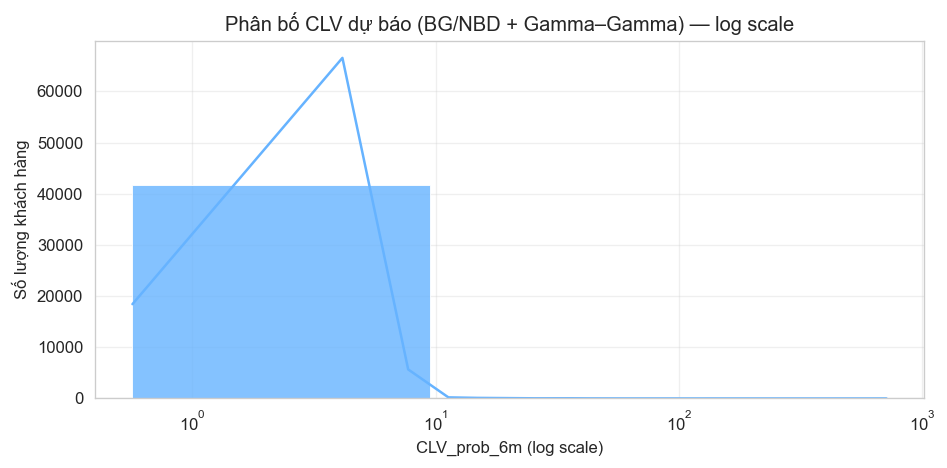

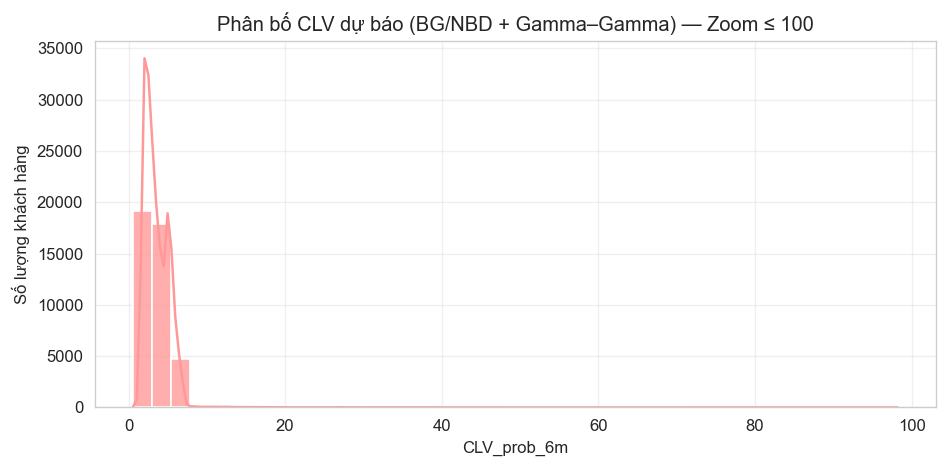

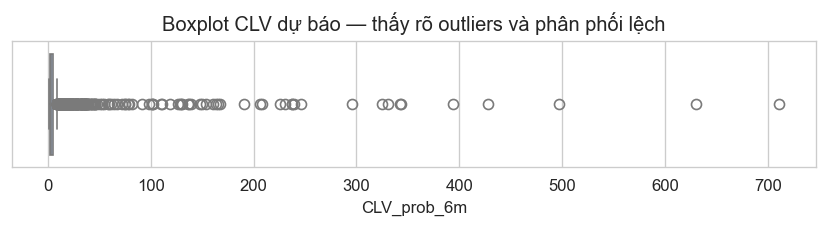

In [38]:
import matplotlib.ticker as mtick

# --- Biểu đồ 1: Toàn bộ phân phối CLV (log scale để xử lý heavy-tail) ---
plt.figure(figsize=(8,4))
sns.histplot(summary['CLV_prob_6m'], bins=80, kde=True, color='#66b3ff', alpha=0.8)
plt.xscale('log')  # log scale giúp “nén” phần đuôi dài
plt.title('Phân bố CLV dự báo (BG/NBD + Gamma–Gamma) — log scale')
plt.xlabel('CLV_prob_6m (log scale)')
plt.ylabel('Số lượng khách hàng')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Biểu đồ 2: Zoom phần CLV nhỏ (≤ 100) để xem rõ “phổ đầu” ---
plt.figure(figsize=(8,4))
sns.histplot(summary.loc[summary['CLV_prob_6m'] <= 100, 'CLV_prob_6m'],
             bins=40, kde=True, color='#ff9999', alpha=0.8)
plt.title('Phân bố CLV dự báo (BG/NBD + Gamma–Gamma) — Zoom ≤ 100')
plt.xlabel('CLV_prob_6m')
plt.ylabel('Số lượng khách hàng')
plt.grid(alpha=0.3)

# Thêm label top giá trị (như 0–20, 20–40,…)
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.show()

# --- Thêm biểu đồ 3: Boxplot để thấy toàn cảnh “phân phối lệch” ---
plt.figure(figsize=(7,2))
sns.boxplot(x=summary['CLV_prob_6m'], color='#99c2ff')
plt.title('Boxplot CLV dự báo — thấy rõ outliers và phân phối lệch')
plt.xlabel('CLV_prob_6m')
plt.tight_layout()
plt.show()


# CALIBRATION DECILE

In [ ]:
from lifetimes.utils import calibration_and_holdout_data

cal_hold_df = calibration_and_holdout_data(
    transactions=trans,
    customer_id_col='customer_unique_id',
    datetime_col='order_date',
    calibration_period_end=CUTOFF,
    observation_period_end=H_END,
    freq='D'
)

In [40]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)


<lifetimes.BetaGeoFitter: fitted with 42066 subjects, a: 0.26, alpha: 57.39, b: 0.05, r: 0.02>

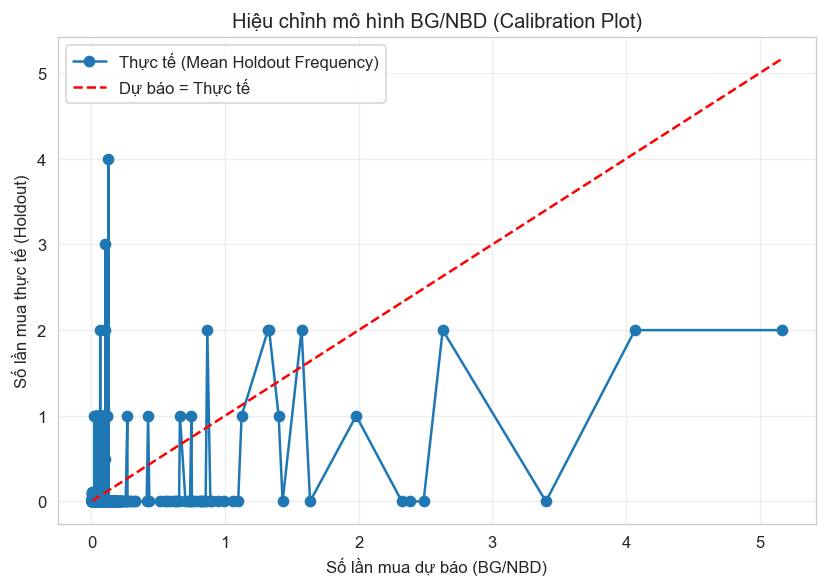

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Dự báo số lần mua trong giai đoạn holdout
t_holdout = cal_hold_df['duration_holdout'].iloc[0]  # số ngày holdout
cal_hold_df['pred_purchases'] = bgf.predict(
    t=t_holdout,
    frequency=cal_hold_df['frequency_cal'],
    recency=cal_hold_df['recency_cal'],
    T=cal_hold_df['T_cal']
)

# Gom theo số lần mua dự báo
grouped = cal_hold_df.groupby('pred_purchases')['frequency_holdout'].mean()

# Vẽ biểu đồ calibration
plt.figure(figsize=(7, 5))
plt.plot(grouped.index, grouped.values, "o-", label="Thực tế (Mean Holdout Frequency)")
plt.plot(grouped.index, grouped.index, "r--", label="Dự báo = Thực tế")
plt.title("Hiệu chỉnh mô hình BG/NBD (Calibration Plot)")
plt.xlabel("Số lần mua dự báo (BG/NBD)")
plt.ylabel("Số lần mua thực tế (Holdout)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#9.Gắn nhãn CLV thực tế & tạo Feature Set

In [42]:
# Nhãn thật (chi tiêu thực tế trong Horizon) - Horizon là 6 tháng đầu của 2018
y_true = (
    test_tx.groupby('customer_unique_id')['order_value'].sum()
    .rename('CLV_actual_6m')
)
summary = summary.merge(y_true, on='customer_unique_id', how='left')
summary['CLV_actual_6m'] = summary['CLV_actual_6m'].fillna(0.0)

# Bổ sung feature hành vi mở rộng (payment/review/items)
agg_base = train_tx[['order_id','customer_unique_id','customer_state']].copy()
feat_aggs = (
    agg_base
    .merge(payments[['order_id','payment_value']], on='order_id', how='left')
    .merge(reviews[['order_id','review_score']], on='order_id', how='left')
    .merge(items[['order_id','product_id']], on='order_id', how='left')
    .groupby('customer_unique_id')
    .agg(
        payment_value_sum   = ('payment_value','sum'),
        payment_value_mean  = ('payment_value','mean'),
        review_score_mean   = ('review_score','mean'),
        num_unique_products = ('product_id', pd.Series.nunique),
        state_mode          = ('customer_state', lambda x: x.mode()[0] if len(x.mode())>0 else np.nan)
    ).reset_index()
)

# Merge features vào bảng summary
summary_ml = summary.merge(feat_aggs, on='customer_unique_id', how='left')
summary_ml.head(5)


,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,303.0,0.0,0.006498,280.695271,1.823989,1.0,0.0,150.12,150.12,4.0,1,RJ
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,167.0,0.0,0.009594,280.695271,2.693117,1.0,0.0,29.00,29.00,3.0,1,ES


In [43]:
calc_null_rate(summary_ml)

,null_count,null_rate
review_score_mean,311,0.007393
frequency,0,0.000000
customer_unique_id,0,0.000000
T,0,0.000000
monetary_value,0,0.000000
pred_purchases_6m,0,0.000000
recency,0,0.000000
pred_avg_value,0,0.000000
CLV_prob_6m,0,0.000000
CLV_actual_6m,0,0.000000


In [44]:
# Xử lý thiếu
# Chỉ còn cột 'review_score_mean' bị thiếu (~0.7% khách)
# Điền giá trị trung vị để giữ phân phối ổn định, tránh mất mẫu
median_review = summary_ml['review_score_mean'].median()
summary_ml['review_score_mean'] = summary_ml['review_score_mean'].fillna(median_review)

print("Tổng số khách hàng:", len(summary_ml))
summary_ml.head(3)

Tổng số khách hàng: 42066


,customer_unique_id,frequency,recency,T,monetary_value,pred_purchases_6m,pred_avg_value,CLV_prob_6m,p_alive,CLV_actual_6m,payment_value_sum,payment_value_mean,review_score_mean,num_unique_products,state_mode
0,0000f46a3911fa3c0805444483337064,0.0,0.0,297.0,0.0,0.006591,280.695271,1.850148,1.0,0.0,86.22,86.22,3.0,1,SC
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,81.0,0.0,0.013880,280.695271,3.895925,1.0,0.0,43.62,43.62,4.0,1,PA
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,48.0,0.0,0.016867,280.695271,4.734350,1.0,0.0,196.89,196.89,5.0,1,SP


#10.Tạo Preprocessor và 3 Pipeline Ứng viên

In [45]:
from sklearn.model_selection import KFold, cross_val_score

# Xác định cột numeric và categorical
numeric_features = [
    'frequency','recency','T','monetary_value',
    'p_alive','CLV_prob_6m',
    'payment_value_sum','payment_value_mean',
    'review_score_mean','num_unique_products'
]
categorical_features = ['state_mode']

# Preprocessor: scale số + OneHotEncode hạng mục
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Chuẩn bị tập X, y
X_final = summary_ml[numeric_features + categorical_features].copy()
y_final = summary_ml['CLV_actual_6m'].astype(float).copy()

# Định nghĩa 3 mô hình
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=400, max_depth=12, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=700, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist', random_state=42
    )
}

# Tạo Pipeline cho từng model
from sklearn.pipeline import Pipeline
pipelines = {
    name: Pipeline([('preprocess', preprocessor), ('model', model)])
    for name, model in models.items()
}


#11.Cross-Validation & Lựa chọn Mô hình Tốt nhất

## 11.1 So sánh mô hình trên toàn bộ tập train
  * Mục đích:

    - Chạy 3 mô hình khác nhau (Linear, RF, XGB) trên cùng dữ liệu.

    - Đo lường độ khớp (fit) trên tập huấn luyện (X_final, y_final).

    - Giúp so sánh nhanh mô hình nào có hiệu năng tổng thể tốt hơn trước khi đi vào đánh giá chính thức.

In [46]:
for model_name in ["LinearRegression", "RandomForest", "XGBoost"]:
    pipe = pipelines[model_name]
    pipe.fit(X_final, y_final)
    y_pred = pipe.predict(X_final)
    print(f"{model_name} → MAE={mean_absolute_error(y_final, y_pred):.3f}, "
          f"RMSE={np.sqrt(mean_squared_error(y_final, y_pred)):.3f}, "
          f"R²={r2_score(y_final, y_pred):.3f}")

LinearRegression → MAE=3.926, RMSE=25.053, R²=0.008
RandomForest → MAE=3.441, RMSE=20.967, R²=0.305
XGBoost → MAE=3.034, RMSE=15.200, R²=0.635


* Nhận xét: Nhận thấy XGBoost cho MAE thấp hơn và R^2 cao nhất trong 3 cái

## 11.2 Kiểm định độ ổn định bằng Cross-Validation (CV)

In [47]:
# ================================================
# ⚙️ CẤU HÌNH CHUNG
# ================================================
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import numpy as np
import pandas as pd

# 3-Fold CV (sau này chỉ cần đổi thành 5 để ra bản chính)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Bảng kết quả tổng hợp
results = []


In [48]:
# ================================================
# 1️⃣ LINEAR REGRESSION (Baseline)
# ================================================
pipe_lin = pipelines["LinearRegression"]

mae_scores = -cross_val_score(pipe_lin, X_final, y_final, cv=cv, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(pipe_lin, X_final, y_final, cv=cv, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(pipe_lin, X_final, y_final, cv=cv, scoring='r2')

print(f"Linear Regression → MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

results.append({
    "Model": "Linear Regression",
    "MAE_mean": mae_scores.mean(),
    "MAE_std": mae_scores.std(),
    "RMSE_mean": rmse_scores.mean(),
    "R2_mean": r2_scores.mean()
})

Linear Regression → MAE: 3.934 ± 0.149


In [49]:
# ================================================
# 2️⃣ RANDOM FOREST (Tuning bằng GridSearchCV)
# ================================================
grid_rf = GridSearchCV(
    estimator=pipelines["RandomForest"],
    param_grid={
        'model__n_estimators': [200, 400],
        'model__max_depth': [8, 12, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# ... (phần code GridSearchCV và .fit() của bạn ở trên) ...

grid_rf.fit(X_final, y_final)

# === PHẦN SỬA ĐỂ IN RA MEAN VÀ STD ===

print(" RF best params:", grid_rf.best_params_)
print(" RF best MAE (Mean):", -grid_rf.best_score_) # Đây là MAE trung bình

# 1. Lấy vị trí (index) của mô hình tốt nhất
best_index_rf = grid_rf.best_index_

# 2. Lấy std của mô hình đó từ 'cv_results_'
best_std_rf = grid_rf.cv_results_['std_test_score'][best_index_rf]

print(" RF best MAE (Std):", best_std_rf) # <--- IN RA STD BẠN CẦN

# === KẾT THÚC PHẦN SỬA ===

best_rf = grid_rf.best_estimator_

# Sửa lại phần results.append của bạn
results.append({
    "Model": "Random Forest",
    "MAE_mean": -grid_rf.best_score_,  # Mean chính xác
    "MAE_std": best_std_rf,            # <--- STD chính xác (đã sửa)
    "RMSE_mean": np.sqrt(-cross_val_score(best_rf, X_final, y_final, cv=cv, scoring='neg_mean_squared_error')).mean(),
    "R2_mean": cross_val_score(best_rf, X_final, y_final, cv=cv, scoring='r2').mean()
})

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 RF best params: {'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
 RF best MAE (Mean): 3.921835515256683
 RF best MAE (Std): 0.16054398016300797


In [50]:
# ================================================
# 3️⃣ XGBOOST (Tuning bằng GridSearchCV)
# ================================================
from xgboost import XGBRegressor

grid_xgb = GridSearchCV(
    estimator=pipelines["XGBoost"],
    param_grid={
        'model__n_estimators': [400, 700],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [4, 6],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__gamma': [0, 0.1]
    },
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_final, y_final)
# ... (Phần grid_xgb.fit(X_final, y_final) của bạn ở trên) ...
print(" XGBoost best params:", grid_xgb.best_params_)
print(" XGBoost best MAE (Mean):", -grid_xgb.best_score_) # Đây là MAE trung bình

# ... (Phần grid_xgb.fit(X_final, y_final) của bạn ở trên) ...

# Lấy vị trí (index) của mô hình tốt nhất
best_index = grid_xgb.best_index_

# Lấy std của mô hình đó từ 'cv_results_'
best_std = grid_xgb.cv_results_['std_test_score'][best_index]

print(" XGBoost best MAE (Std):", best_std) 

# ---> Dòng KHÔNG THỂ THIẾU <---
best_xgb = grid_xgb.best_estimator_ 

# Sửa lại phần results.append của bạn
results.append({
    "Model": "XGBoost",
    "MAE_mean": -grid_xgb.best_score_, # Mean chính xác
    "MAE_std": best_std,              # STD chính xác
    "RMSE_mean": np.sqrt(-cross_val_score(best_xgb, X_final, y_final, cv=cv, scoring='neg_mean_squared_error')).mean(),
    "R2_mean": cross_val_score(best_xgb, X_final, y_final, cv=cv, scoring='r2').mean()
})

Fitting 5 folds for each of 64 candidates, totalling 320 fits
 XGBoost best params: {'model__colsample_bytree': 0.8, 'model__gamma': 0.1, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 400, 'model__subsample': 1.0}
 XGBoost best MAE (Mean): 3.9977848105584846
 XGBoost best MAE (Std): 0.1345446387259961


In [51]:
# ================================================
# 4️⃣ LIGHTGBM (Thêm mô hình mới + tuning)
# ================================================
from lightgbm import LGBMRegressor

# tạo pipeline tạm thời vì bạn chưa có LightGBM trong dict ban đầu
from sklearn.pipeline import Pipeline
pipe_lgb = Pipeline([
    ('preprocess', preprocessor),
    ('model', LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)) # Thêm verbose=-1 vào đây để nó "im lặng"
])

grid_lgb = GridSearchCV(
    estimator=pipe_lgb,
    param_grid={
        'model__num_leaves': [31, 50, 80],
        'model__max_depth': [-1, 8],
        'model__learning_rate': [0.05, 0.1],
        'model__n_estimators': [400, 700],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__min_child_samples': [10, 20]
    },
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# ... (phần code GridSearchCV và .fit() của bạn ở trên) ...

grid_lgb.fit(X_final, y_final)

# === PHẦN SỬA ĐỂ IN RA MEAN VÀ STD ===

print("✅ LightGBM best params:", grid_lgb.best_params_)
print("✅ LightGBM best MAE (Mean):", -grid_lgb.best_score_) # Đây là MAE trung bình

# 1. Lấy vị trí (index) của mô hình tốt nhất
best_index_lgb = grid_lgb.best_index_

# 2. Lấy std của mô hình đó từ 'cv_results_'
best_std_lgb = grid_lgb.cv_results_['std_test_score'][best_index_lgb]

print("✅ LightGBM best MAE (Std):", best_std_lgb) # <--- IN RA STD BẠN CẦN

# === KẾT THÚC PHẦN SỬA ===

best_lgb = grid_lgb.best_estimator_

# Sửa lại phần results.append của bạn
results.append({
    "Model": "LightGBM",
    "MAE_mean": -grid_lgb.best_score_,  # Mean chính xác
    "MAE_std": best_std_lgb,            # <--- STD chính xác (đã sửa)
    "RMSE_mean": np.sqrt(-cross_val_score(best_lgb, X_final, y_final, cv=cv, scoring='neg_mean_squared_error')).mean(),
    "R2_mean": cross_val_score(best_lgb, X_final, y_final, cv=cv, scoring='r2').mean()
})

Fitting 5 folds for each of 192 candidates, totalling 960 fits
✅ LightGBM best params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 8, 'model__min_child_samples': 20, 'model__n_estimators': 400, 'model__num_leaves': 31, 'model__subsample': 0.8}
✅ LightGBM best MAE (Mean): 4.152234821464153
✅ LightGBM best MAE (Std): 0.12636888440341446


#12.Huấn luyện mô hình Random Forest Final

In [52]:
from sklearn.ensemble import RandomForestRegressor  # <-- THAY ĐỔI
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np # (Cần cho np.sqrt)

# --- Lấy lại preprocessor & cấu hình model Random Forest tốt nhất ---

# !!! QUAN TRỌNG: Bạn PHẢI thay thế các giá trị dưới đây
# bằng các hyperparameter TỐT NHẤT bạn tìm được từ GridSearchCV
rf_final = RandomForestRegressor(
    n_estimators=500,       # <-- Thay bằng giá trị best_params_ của bạn
    max_depth=10,           # <-- Thay bằng giá trị best_params_ của bạn
    min_samples_leaf=4,     # <-- Thay bằng giá trị best_params_ của bạn
    max_features='sqrt',    # <-- Thay bằng giá trị best_params_ của bạn
    random_state=42,
    n_jobs=-1               # (Nên thêm để chạy nhanh hơn)
)

pipe_rf_final = Pipeline([
    ('preprocess', preprocessor),
    ('model', rf_final)     # <-- THAY ĐỔI
])

# --- Fit mô hình trên toàn bộ dữ liệu ---
print("Đang huấn luyện mô hình Random Forest FINAL trên toàn bộ dữ liệu ...")
pipe_rf_final.fit(X_final, y_final)

# --- Lưu pipeline đã huấn luyện ---
joblib.dump(pipe_rf_final, 'clv_pipeline_rf.joblib') # <-- THAY ĐỔI TÊN FILE
print("Đã lưu mô hình pipeline tại: clv_pipeline_rf.joblib") # <-- THAY ĐỔI TÊN FILE

Đang huấn luyện mô hình Random Forest FINAL trên toàn bộ dữ liệu ...
Đã lưu mô hình pipeline tại: clv_pipeline_rf.joblib


#13.Dự báo CLV Final & Đánh giá

In [53]:
# Dự báo CLV cho toàn bộ khách hàng
y_pred_final = pipe_rf_final.predict(X_final)

# Tính sai số & R²
mae_final  = mean_absolute_error(y_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_final, y_pred_final))
r2_final   = r2_score(y_final, y_pred_final)

print("=== Kết quả mô hình Random Forest FINAL ===") # <-- THAY ĐỔI TIÊU ĐỀ
print(f"MAE = {mae_final:.3f}")
print(f"RMSE = {rmse_final:.3f}")
print(f"R² = {r2_final:.3f}")

=== Kết quả mô hình Random Forest FINAL ===
MAE = 3.818
RMSE = 24.139
R² = 0.079


#14.Phân tích tầm quan trọng đặc trưng (Feature Importance)

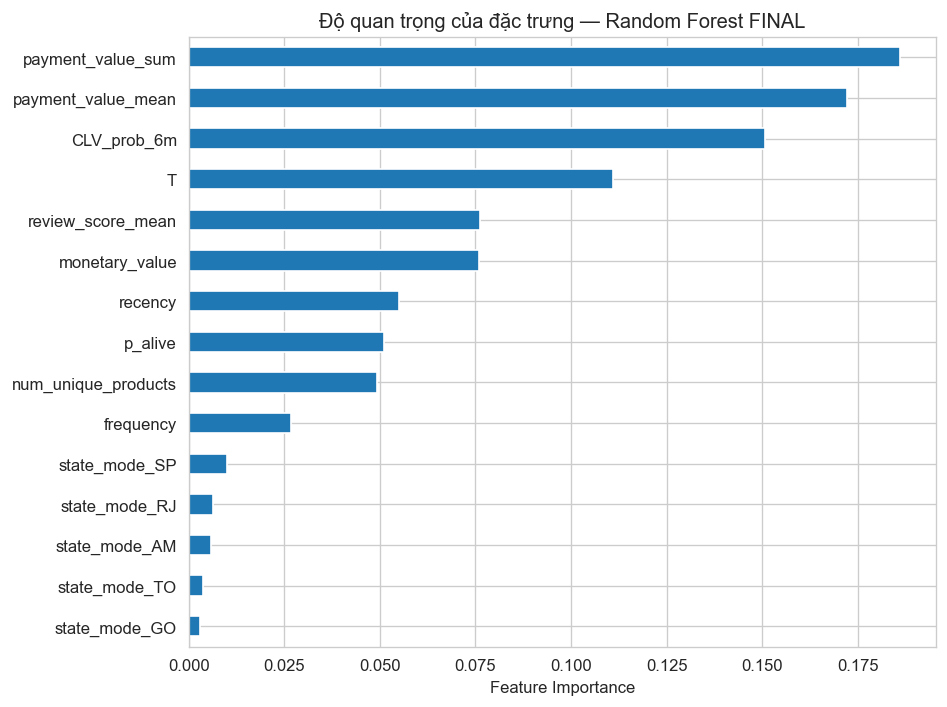

In [54]:
# --- Lấy tên cột sau khi qua preprocessor ---
num_names = numeric_features
cat_names = list(
    pipe_rf_final.named_steps['preprocess'] # <-- THAY ĐỔI
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)
all_feature_names = num_names + cat_names

# --- Lấy importance từ model ---
feature_importance = pipe_rf_final.named_steps['model'].feature_importances_ # <-- THAY ĐỔI

# --- Tạo bảng importance ---
imp_df = pd.Series(feature_importance, index=all_feature_names).sort_values(ascending=True)

plt.figure(figsize=(8,6))
imp_df.tail(15).plot(kind='barh')
plt.title("Độ quan trọng của đặc trưng — Random Forest FINAL") # <-- THAY ĐỔI TIÊU ĐỀ
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

# Bổ sung


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 547.8/547.8 kB 10.6 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.7 MB 35.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 6.5 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   --------- ------------------------------ 9.2/38.1 MB 48.1 MB/s eta 0:00:01
   --------------- ------------------------ 14.9/38.1 MB 36.8 MB/s eta 0:00:01
   ------------------- -------------------- 18.9/38.1 MB 30.8 MB/s eta 0:00:01
   ------------------------ --------------- 23.1/38.1 MB 28.2 MB/s eta 0:00:01
   ---------------------------- ----------- 27.3/38.1 MB 26.9 MB/s eta 0:00:01
   --------------------------------- ------ 31.7/38.1 MB 26.0 MB/s eta 0:00:01
   ------------------------------------- -- 35.9/38.1 MB 25.3 MB/s eta 0:00:01
   -------

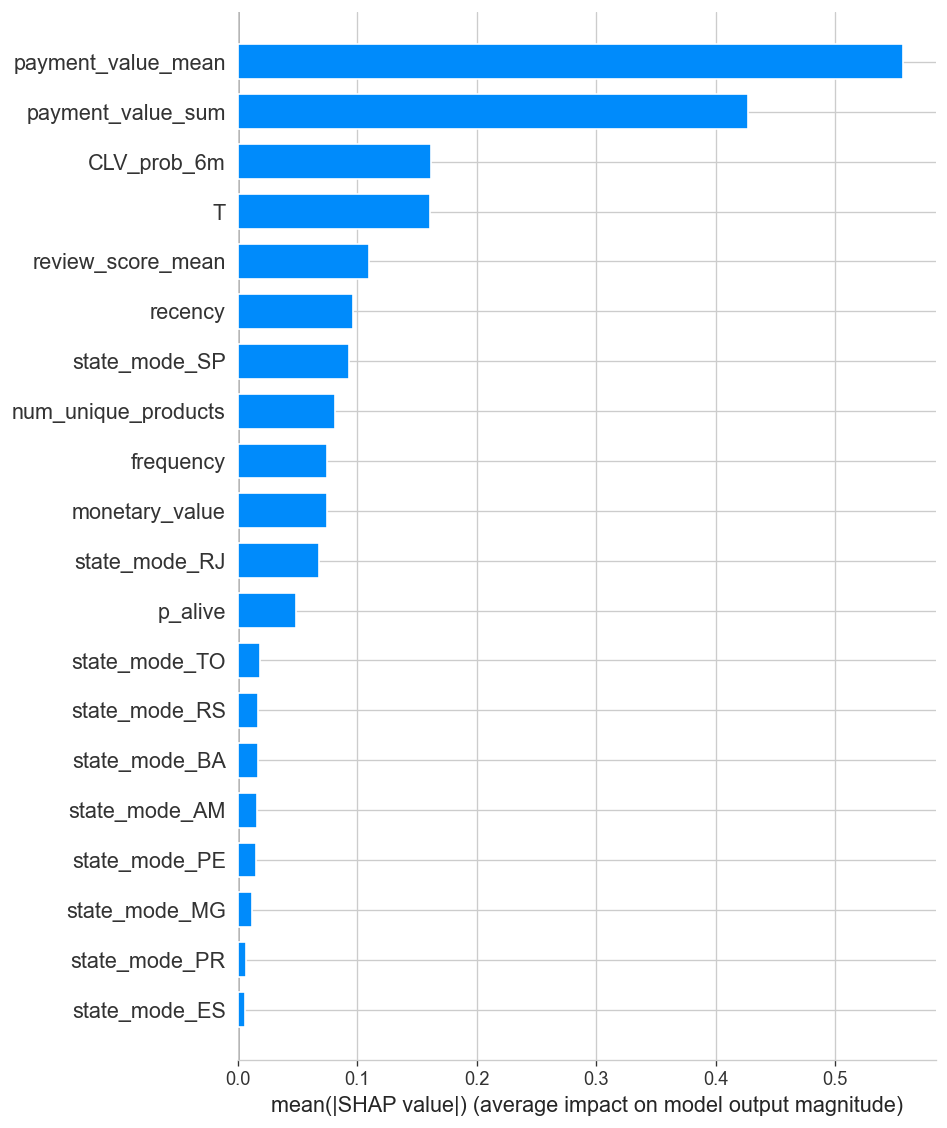

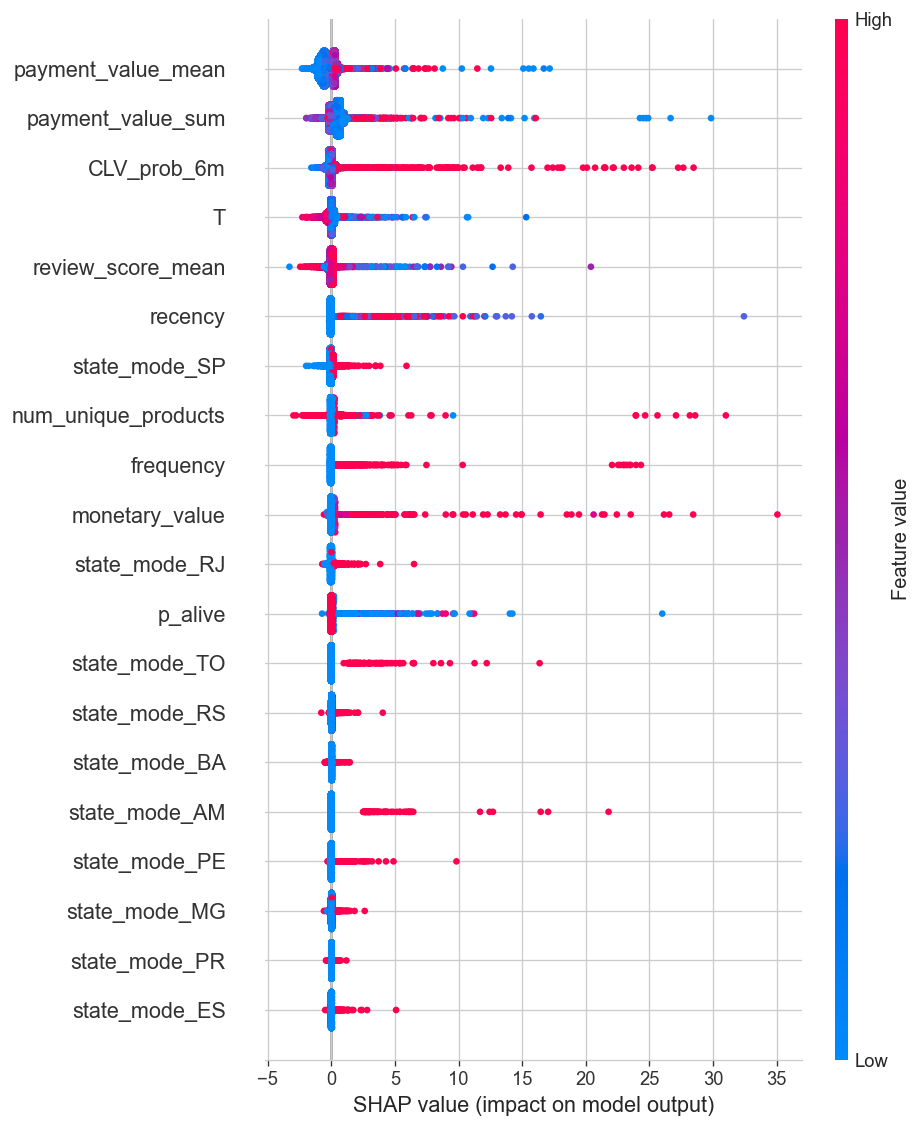

In [55]:
# ----------------------------------------------------
# MỤC 14b: PHÂN TÍCH SHAP (NÂNG CAO)
# ----------------------------------------------------

# 1. Cài đặt thư viện SHAP
!pip install shap

import shap
import pandas as pd

# 2. Lấy model và preprocessor đã huấn luyện từ pipeline
# (Giả sử pipeline của bạn tên là pipe_rf_final)
model = pipe_rf_final.named_steps['model']
preprocessor = pipe_rf_final.named_steps['preprocess']

# 3. Lấy tên feature sau khi đã OHE (bạn đã có ở cell 14)
# Đảm bảo biến 'all_feature_names' đã tồn tại từ cell 14
# all_feature_names = num_names + cat_names 

# 4. Transform dữ liệu X_final (dùng preprocessor đã fit)
# OneHotEncoder tạo ra ma trận thưa (sparse), cần .toarray()
X_final_transformed = preprocessor.transform(X_final).toarray()

# 5. Tạo DataFrame từ dữ liệu đã transform (quan trọng để SHAP plot đẹp)
# Dùng 'all_feature_names' đã lấy được ở cell 14
X_final_transformed_df = pd.DataFrame(X_final_transformed, columns=all_feature_names)

# 6. Tạo explainer (TreeExplainer cho Random Forest)
print("\nĐang tạo SHAP explainer...")
explainer = shap.TreeExplainer(model)

# 7. Tính toán SHAP values (có thể mất vài phút)
print("Đang tính SHAP values...")
shap_values = explainer.shap_values(X_final_transformed_df)

print("Hoàn tất! Đang vẽ biểu đồ...")

# 8. Vẽ biểu đồ summary (kiểu bar - giống feature importance)
shap.summary_plot(shap_values, X_final_transformed_df, plot_type="bar", title="SHAP Feature Importance (RF)")

# 9. Vẽ biểu đồ summary (kiểu dot - δείχνει ảnh hưởng +/-)
shap.summary_plot(shap_values, X_final_transformed_df, title="SHAP Summary Plot (RF)")

#15.So sánh thực tế vs dự báo & Phân khúc khách hàng

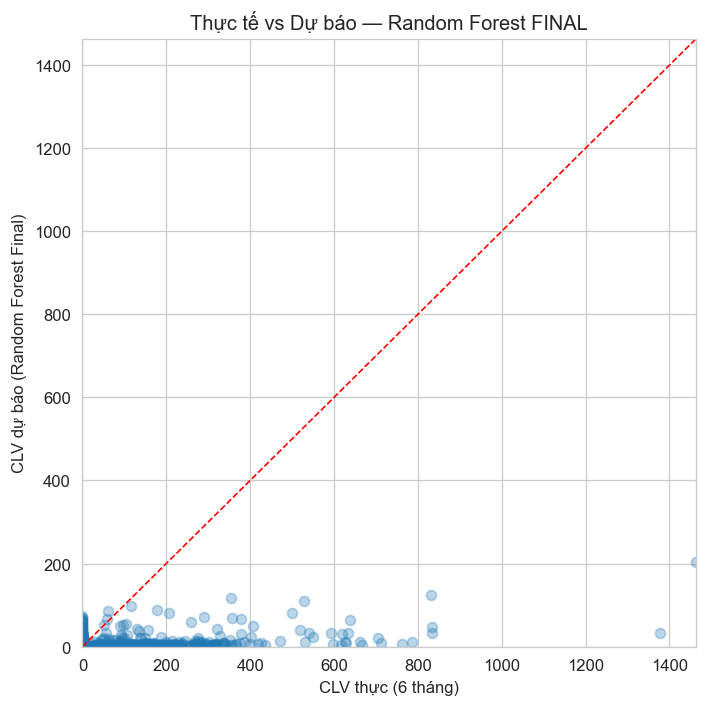

,count,mean,sum
Segment,,,
Low,13882,1.272989,17671.636380
Mid,13881,1.699072,23584.824691
High,14303,3.016254,43141.480373


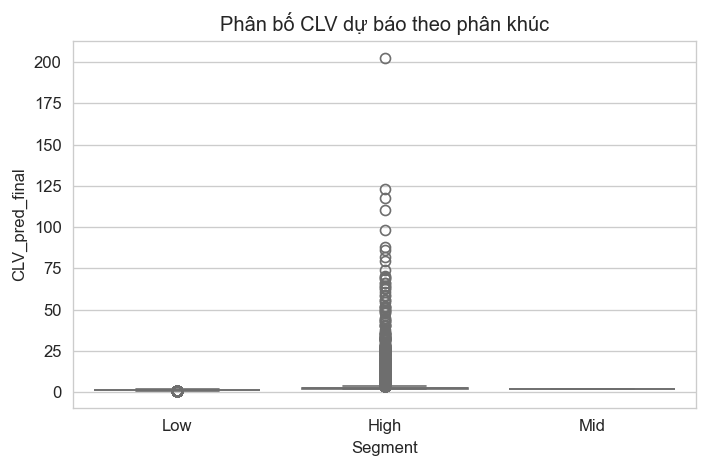

In [56]:
# Thêm vào bảng tổng hợp
# (Đảm bảo y_pred_final là từ mô hình RF ở bước 2)
summary_ml['CLV_pred_final'] = np.maximum(y_pred_final, 0)

# Vẽ scatter để so sánh
plt.figure(figsize=(6,6))
plt.scatter(y_final, y_pred_final, alpha=0.3)
lim = [0, max(y_final.max(), y_pred_final.max())]
plt.plot(lim, lim, 'r--', linewidth=1)
plt.xlim(lim); plt.ylim(lim)
plt.xlabel('CLV thực (6 tháng)')
plt.ylabel('CLV dự báo (Random Forest Final)') # <-- THAY ĐỔI TIÊU ĐỀ
plt.title('Thực tế vs Dự báo — Random Forest FINAL') # <-- THAY ĐỔI TIÊU ĐỀ
plt.tight_layout(); plt.show()

# --- Phân khúc theo quantile 33/66 ---
# (Logic này giữ nguyên)
q33, q66 = np.quantile(summary_ml['CLV_pred_final'], [0.33, 0.66])

def seg(v):
    if v <= q33: return 'Low'
    elif v <= q66: return 'Mid'
    else: return 'High'

summary_ml['Segment'] = summary_ml['CLV_pred_final'].apply(seg)

# Thống kê từng phân khúc
seg_stats = summary_ml.groupby('Segment')['CLV_pred_final'].agg(['count','mean','sum']).sort_values('mean')
display(seg_stats)

# Boxplot CLV theo phân khúc
import seaborn as sns
plt.figure(figsize=(6,4))
sns.boxplot(x='Segment', y='CLV_pred_final', data=summary_ml, palette='coolwarm')
plt.title('Phân bố CLV dự báo theo phân khúc')
plt.tight_layout(); plt.show()

#16.Xuất CSV kết quả - 3 outputs

In [57]:
# --- Lưu output ---
OUT_DIR = './clv_outputs_final_rf' # <-- THAY ĐỔI THƯ MỤC
import os; os.makedirs(OUT_DIR, exist_ok=True)

out_pred = summary_ml[['customer_unique_id','p_alive','CLV_prob_6m',
                       'CLV_actual_6m','CLV_pred_final','Segment']]

# THAY ĐỔI TÊN FILE
out_pred.to_csv(f'{OUT_DIR}/customer_clv_predictions_rf.csv', index=False)
seg_stats.to_csv(f'{OUT_DIR}/segment_stats_rf.csv')
imp_df.sort_values(ascending=False).to_csv(f'{OUT_DIR}/rf_feature_importance.csv')

print("Đã lưu toàn bộ kết quả vào thư mục:", OUT_DIR)

Đã lưu toàn bộ kết quả vào thư mục: ./clv_outputs_final_rf


# Phần 2: Đưa ra Insights (dựa theo số liệu và biểu đồ in ra)

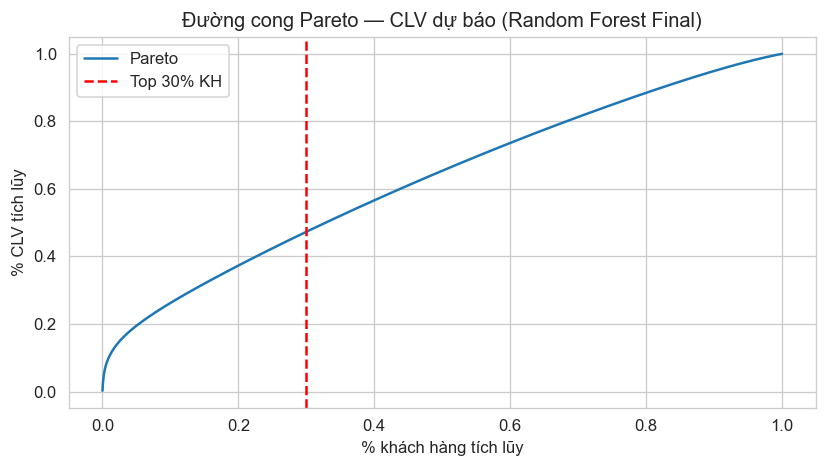

In [58]:
# (Đảm bảo summary_ml đã có cột 'CLV_pred_final' và 'Segment' từ bước 4)

# Sắp xếp và tính toán % tích lũy
srt = summary_ml.sort_values('CLV_pred_final', ascending=False).reset_index(drop=True)
srt['cum_customers'] = (np.arange(len(srt)) + 1) / len(srt)
srt['cum_value'] = srt['CLV_pred_final'].cumsum() / srt['CLV_pred_final'].sum()

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
plt.plot(srt['cum_customers'], srt['cum_value'], label='Pareto')
plt.axvline(0.3, color='r', linestyle='--', label='Top 30% KH')
plt.title('Đường cong Pareto — CLV dự báo (Random Forest Final)') # <-- THAY ĐỔI
plt.xlabel('% khách hàng tích lũy')
plt.ylabel('% CLV tích lũy')
plt.legend(); plt.tight_layout(); plt.show()



In [59]:
# Top 10 khách hàng có CLV cao nhất
top10 = summary_ml.sort_values('CLV_pred_final', ascending=False).head(10)
print("--- Top 10 Khách hàng có CLV dự báo cao nhất ---")
display(top10[['customer_unique_id','CLV_pred_final','Segment']])

--- Top 10 Khách hàng có CLV dự báo cao nhất ---


,customer_unique_id,CLV_pred_final,Segment
41807,fe81bb32c243a86b2f86fbf053fe6140,202.866865,High
4911,1da09dd64e235e7c2f29a4faff33535c,123.281134,High
4523,1b6c7548a2a1f9037c1fd3ddfed95f33,117.678796,High
10244,3e43e6105506432c953e165fb2acf44c,110.636646,High
23155,8d50f5eadf50201ccdcedfb9e2ac8455,98.115338,High
16559,6469f99c1f9dfae7733b25662e7f1782,88.224538,High
11839,47c1a3033b8b77b3ab6e109eb4d5fdf3,85.930151,High
24996,9832ae2f7d3e5fa4c7a1a06e9551bc61,82.035522,High
16466,63cfc61cee11cbe306bff5857d00bfe4,79.708484,High
27506,a7657330b1c135f3acd420326e335b2c,74.221621,High


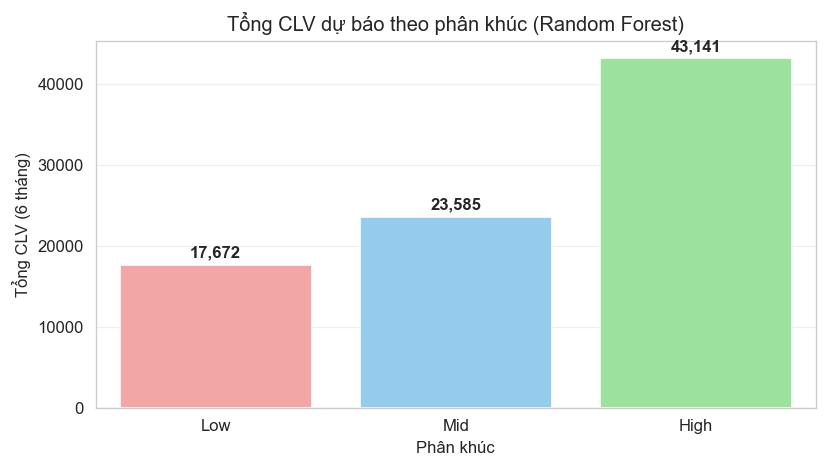

In [60]:
# (Đảm bảo seg_stats đã được tạo ở bước 4)
# seg_stats = summary_ml.groupby('Segment')['CLV_pred_final'].agg(['count','mean','sum']).sort_values('mean')

# --- Bar chart tổng CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='sum', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'])
plt.title('Tổng CLV dự báo theo phân khúc (Random Forest)') # <-- THAY ĐỔI
plt.ylabel('Tổng CLV (6 tháng)')
plt.xlabel('Phân khúc')

# Hiển thị nhãn giá trị trên đầu cột
for i, v in enumerate(seg_stats.loc[seg_stats.index]['sum']): # (Sửa nhỏ để lấy đúng thứ tự)
    plt.text(i, v + seg_stats['sum'].max()*0.02, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

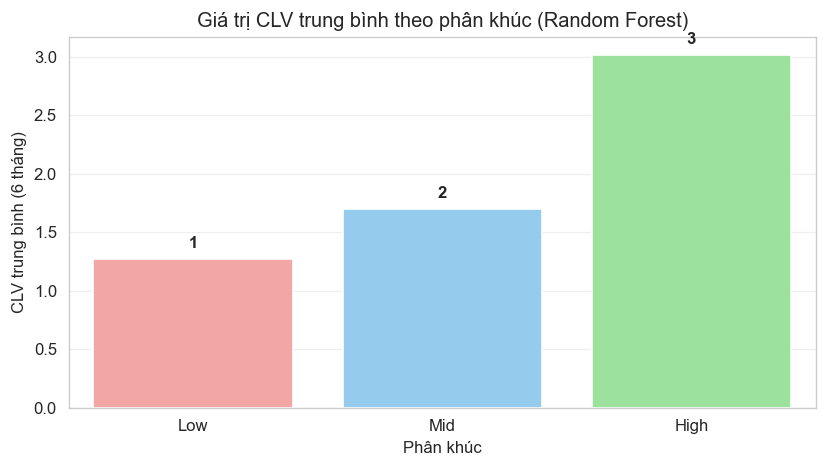

In [61]:
# --- Bar chart trung bình CLV theo phân khúc ---
plt.figure(figsize=(7,4))
sns.barplot(x=seg_stats.index, y='mean', data=seg_stats.reset_index(),
            palette=['#FF9999', '#87CEFA', '#90EE90'])
plt.title('Giá trị CLV trung bình theo phân khúc (Random Forest)') # <-- THAY ĐỔI
plt.ylabel('CLV trung bình (6 tháng)')
plt.xlabel('Phân khúc')

for i, v in enumerate(seg_stats.loc[seg_stats.index]['mean']): # (Sửa nhỏ để lấy đúng thứ tự)
    plt.text(i, v + seg_stats['mean'].max()*0.03, f"{v:,.0f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

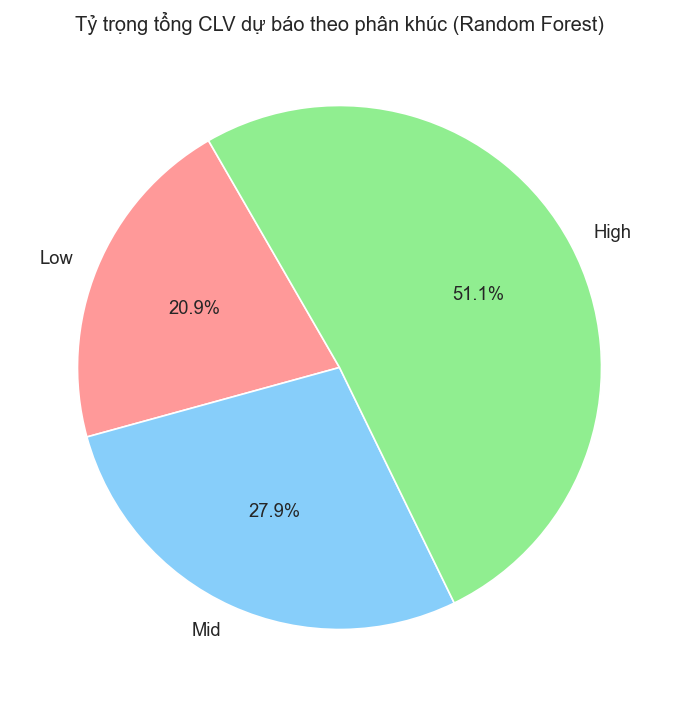

In [62]:
# --- Pie chart thể hiện tỉ trọng tổng CLV ---
plt.figure(figsize=(6,6))
colors = ['#FF9999', '#87CEFA', '#90EE90']
plt.pie(seg_stats['sum'], labels=seg_stats.index, autopct='%1.1f%%',
        startangle=120, colors=colors, textprops={'fontsize':11})
plt.title('Tỷ trọng tổng CLV dự báo theo phân khúc (Random Forest)') # <-- THAY ĐỔI
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
import numpy as np

# (Đảm bảo OUT_DIR đã được định nghĩa ở bước 5)
# OUT_DIR = './clv_outputs_final_rf' 

# Đọc dữ liệu dự báo CLV
out_pred = pd.read_csv(f"{OUT_DIR}/customer_clv_predictions_rf.csv") # <-- ĐỌC FILE RF

# Tính toán Pareto
clv = out_pred["CLV_pred_final"].clip(lower=0)
out_pred = out_pred.assign(_clv=clv).sort_values("_clv", ascending=False).reset_index(drop=True)
out_pred["cum_cust_pct"] = (np.arange(len(out_pred)) + 1) / len(out_pred)
out_pred["cum_clv"] = out_pred["_clv"].cumsum()
total_clv = out_pred["_clv"].sum()
out_pred["cum_clv_pct"] = out_pred["cum_clv"] / total_clv

# In ra các mốc % CLV
print("--- Báo cáo Phân bổ Pareto (Random Forest) ---")
for t in [0.5, 0.7, 0.8, 0.9]:
    try:
        share = out_pred.loc[out_pred["cum_clv_pct"] >= t, "cum_cust_pct"].iloc[0]
        print(f"{int(t*100)}% tổng CLV đạt được bởi {share:.1%} khách hàng")
    except IndexError:
        print(f"Không đạt được mốc {int(t*100)}% CLV.")

--- Báo cáo Phân bổ Pareto (Random Forest) ---
50% tổng CLV đạt được bởi 32.8% khách hàng
70% tổng CLV đạt được bởi 55.5% khách hàng
80% tổng CLV đạt được bởi 68.2% khách hàng
90% tổng CLV đạt được bởi 82.3% khách hàng


In [64]:
# Đọc file phân khúc
seg_stats_table = pd.read_csv(f"{OUT_DIR}/segment_stats_rf.csv") # <-- ĐỌC FILE RF
seg_stats_table.rename(columns=str.lower, inplace=True)

# Tính tỷ lệ KH và CLV
seg_stats_table["share_customers"] = seg_stats_table["count"] / seg_stats_table["count"].sum()
seg_stats_table["share_clv"] = seg_stats_table["sum"] / seg_stats_table["sum"].sum()

# Làm tròn & định dạng bảng
seg_stats_table["share_customers_fmt"] = (seg_stats_table["share_customers"]*100).round(0).astype(int).astype(str).radd("~").add("%")
seg_stats_table["share_clv_fmt"] = (seg_stats_table["share_clv"]*100).round(0).astype(int).astype(str).radd("~").add("%")
table = seg_stats_table[["segment", "share_customers_fmt", "share_clv_fmt"]]
table.columns = ["Phân khúc", "Tỷ lệ khách hàng", "Tỷ lệ CLV"]

print("\n📊 Phân khúc khách hàng theo CLV (Random Forest):")
print(table.to_string(index=False))


📊 Phân khúc khách hàng theo CLV (Random Forest):
Phân khúc Tỷ lệ khách hàng Tỷ lệ CLV
      Low             ~33%      ~21%
      Mid             ~33%      ~28%
     High             ~34%      ~51%


In [65]:
# (Đảm bảo out_pred đã được tính ở bước 9)

# === Từ đây là đoạn tóm tắt ===
n_customers = len(out_pred)
mean_clv = out_pred["_clv"].mean()
median_clv = out_pred["_clv"].median()
p95_clv = out_pred["_clv"].quantile(0.95)
try:
    share_80pct = out_pred.loc[out_pred["cum_clv_pct"] >= 0.8, "cum_cust_pct"].iloc[0]
    share_80_text = f"- Top {share_80pct*100:.1f}% khách hàng nắm giữ 80% tổng CLV dự báo."
except IndexError:
    share_80_text = "- (Không đạt mốc 80% CLV)"


print("\n🧾 Tóm tắt nhanh insight mô hình CLV (Random Forest):")
print(f"- Số khách hàng: {n_customers:,}")
print(f"- CLV trung bình: {mean_clv:,.2f}")
print(f"- CLV trung vị: {median_clv:,.2f}")
print(f"- CLV 95th percentile: {p95_clv:,.2f}")
print(share_80_text)


🧾 Tóm tắt nhanh insight mô hình CLV (Random Forest):
- Số khách hàng: 42,066
- CLV trung bình: 2.01
- CLV trung vị: 1.70
- CLV 95th percentile: 3.14
- Top 68.2% khách hàng nắm giữ 80% tổng CLV dự báo.
